# Deutsch-Jorsza algorithm

## Problem

We have a function $f: Z_2^n \rightarrow Z_2$ which accepts n bits and outputs 0 or 1. We know that the function can either be **constant**, i.e. it outputs the same value on all $2^n$ inputs, or **balanced**, i.e. it outputs the same number of 0s and 1s.

The classical algorithm to determine whether the function is balanced or constant has complexity in the worst case of O(2^n) on the number of bits. Infact, it may happen that we get $f(x_1) \ne f(x_2)$ for the first two sampled inputs and conclude that $f$ is balanced. However, to conclude with certainty that it is constant, we must sample and compute $2^{n-1}+1$ samples among the inputs (i.e. half the inputs plus 1).

## Quantum Algorithm

Using a quantum algorithm we can solve this with certainty by computing $f(x)$ only once, but we need to implement a quantum oracle which implements the function $f(x)$. We will implement the function with a quantum oracle $U_f |x, y> = |x, y \oplus f(x)>$, where $\oplus$ is the XOR operation.

We start with the state $|\psi_0> = |0^{\otimes n}, 1>$ and apply and Hadamard gate to each qubit.

In [42]:
import numpy as np
from sys import exit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, Aer, execute, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit_textbook.tools import array_to_latex

So that the state ends up being:

$$
|\psi_1> = \frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^n-1} |x> \otimes (|0> - |1>)
$$

We now apply the oracle saw above, so the state will be:

$$
|\psi_2> = \frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^n-1} |x> \otimes \big(|f(x)> - |1 \oplus f(x)> \big) \\
= \frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^n-1} (-1)^{f(x)} |x> \otimes \big(|0> - |1>\big)
$$

Thus by applying it to states of the form $|x, ->$ we turned the Boolean oracle (kind of a boolean oracle) into a phase oracle, with $(-1)^{f(x)}$ relative phases between states in the superposition (only works because $f(x) \in \{0,1\}$).

Now, the second register (one last qubit) role was to kickback this relative phase between the $|x>$ states, and we can ignore it from now on.

We now apply a Hadamard to each qubit in the first register and obtain:

$$
|\psi_3> = \frac{1}{2^n} \sum_{x=0}^{2^n-1} (-1)^{f(x)} \Bigg[\sum_{y=0}^{2^n-1} (-1)^{x \cdot y} |y> \Bigg]\\
= \frac{1}{2^n} \sum_{y=0}^{2^n-1} \Bigg[\sum_{x=0}^{2^n-1} (-1)^{f(x)} (-1)^{x \cdot y} \Bigg] |y>
$$

where $x \cdot y = x_0 y_0 \oplus \dots \oplus x_{n-1} y_{n-1}$. Last thing, measure the whole first register, and notice that the probability of measuring $|0^{\otimes n}>$ is 0 if $f(x)$ is balanced and 1 if it's constant:

$$
P(|0^{\otimes n}>) = |\frac{1}{2^n} \sum_{x=0}^{2^n-1} (-1)^{f(x)}|^2
$$


Widget to try the algorithm on a 2 qubit XOR function (the oracle is implemented as $Q_f=CX_{13}CX_{23}$)

In [2]:
from qiskit_textbook.widgets import dj_widget
dj_widget(size="large", case="balanced")

HTMLMath(value='$$ |0000\\rangle = |0000\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x05\x00\x00\x01E\x08\x06\x00\x00\x00\xe5\xce\xf8…

## Creating quantum oracles

For a constant function is pretty straightforward:
    
1. if $f(x)=0$ just apply $I$ to the qubit in the second register
2. if $f(x)=1$ just apply $X$ to the qubit in the second register

This will result in the second case with a global -1 phase factor which can be ignored.

For a balanced function we can have different circuits. For example, we can apply a CNOT for each qubit in the first register and targeted at the second register, e.g.

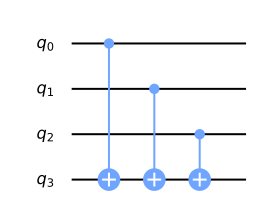

In [3]:
qc_ex = QuantumCircuit(4)
for i in range(3):
    qc_ex.cx(i,3)
qc_ex.draw()

If we wrap selected control bits with the $X$ gate, the resulting oracle will still be balanced, and will differ in the inputs that give 0 or 1.

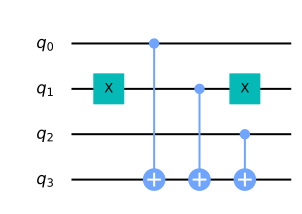

In [4]:
qc_ex = QuantumCircuit(4)
qc_ex.x(1)
for i in range(3):
    qc_ex.cx(i,3)
qc_ex.x(1)
qc_ex.draw()

This way we can build any balanced function output.

## Implementation

We will implement the DJ algorithm for a three bit function.

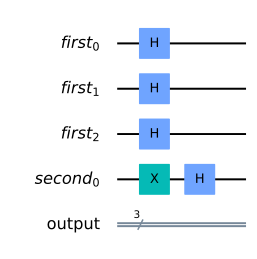

In [99]:
n = 3
qr_1 = QuantumRegister(n, name='first')
qr_2 = QuantumRegister(1, name='second')
c_out = ClassicalRegister(n, name='output')
init_circuit = QuantumCircuit(qr_1,qr_2, c_out)
init_circuit.h(qr_1)
init_circuit.x(qr_2)
init_circuit.h(qr_2)
init_circuit.draw()

### Constant oracle

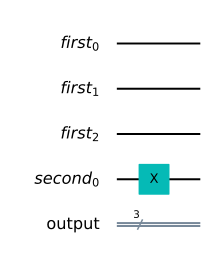

In [100]:
constant_oracle = QuantumCircuit(qr_1, qr_2, c_out)
output = np.random.randint(2)
if output == 1:
    constant_oracle.x(n)
constant_oracle.draw()

i.e. since the input doesn't matter, we randomly set the function to have output 0 or 1 and just apply X to the second register if the output is 1. This will give a global -1 phase which doesn't affect the state.

### Balanced oracle

We use the circuit seen above. We will generate a bit string which will tell which input qubit to wrap in X gates, so as to determine which inputs give 0 and which give 1.

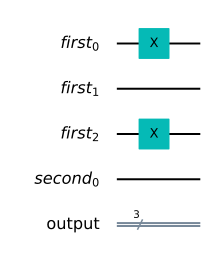

In [101]:
balanced_oracle = QuantumCircuit(qr_1, qr_2, c_out)
b_str = "101"

for qubit in range(len(b_str)):
    if b_str[qubit]=='1':
        balanced_oracle.x(qubit)

balanced_oracle.draw()

Next we apply our CNOT gates on all qubits.

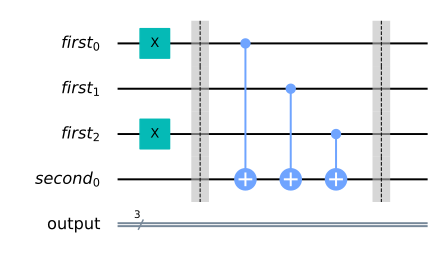

In [102]:
balanced_oracle.barrier()
for qubit in range(3):
    balanced_oracle.cx(qubit,n)

balanced_oracle.barrier()
balanced_oracle.draw()

Last, we need to apply the same x gates as before, the whole operation is:

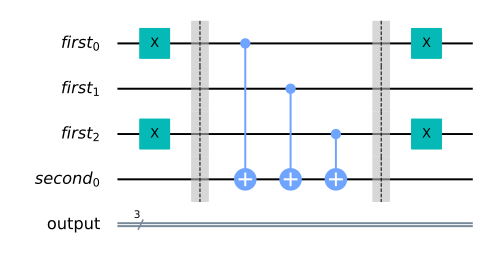

In [103]:
balanced_oracle = QuantumCircuit(qr_1, qr_2, c_out)
b_str = "101"

for qubit in range(len(b_str)):
    if b_str[qubit]=='1':
        balanced_oracle.x(qubit)

balanced_oracle.barrier()
for qubit in range(3):
    balanced_oracle.cx(qubit,n)

balanced_oracle.barrier()

for qubit in range(len(b_str)):
    if b_str[qubit]=='1':
        balanced_oracle.x(qubit)

balanced_oracle.draw()

### Algorithm

The algorithm thus is: initialize with hadamards, apply oracle and apply hadamards again. Then measure and see if the output is all 0s.

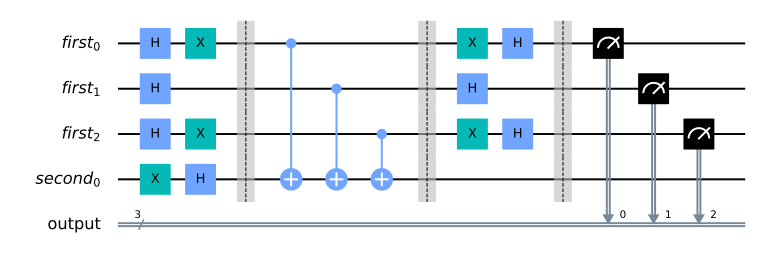

In [104]:
dj_circuit = init_circuit + balanced_oracle
dj_circuit.h(qr_1)
dj_circuit.barrier()
dj_circuit.measure(qr_1, c_out)
dj_circuit.draw()

In [105]:
aer_backend = BasicAer.get_backend('qasm_simulator')

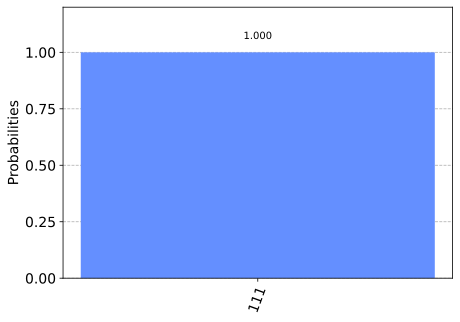

In [106]:
shots = 1024
results = execute(dj_circuit, aer_backend).result().get_counts()
plot_histogram(results)

### Generalized function to create DJ oracles

We create a function that takes a case ('balanced' or 'constant') and the first and second quantum registers, and gives back a set of gates that apply the oracle operatino as seen above.

In [108]:
def dj_oracle(case, qr_1, qr_2):
    oracle_qc = QuantumCircuit(qr_1,qr_2)
    n = qr_1.size
    if case == 'balanced':
        b = np.random.randint(1, 2**n) #random int in [1,2**n)
        #we convert the string to binary, by using format
        #format(vale, format_spec)
        #were here format spec means that we want a n lenght binary string
        #and if it is shorter pad it with 0s
        b_str = format(b, '0'+str(n)+'b')
        print("Oracle bit string: ", b_str)
        for qubit in range(len(b_str)):
            if b_str[qubit]=='1':
                #applies the X if the corresponding bit is 1
                oracle_qc.x(qubit)
        #apply the CNOTs on all qubits in the first register, target on the second
        oracle_qc.cx(qr_1, qr_2)
        #reapply X
        for qubit in range(len(b_str)):
            if b_str[qubit]=='1':
                oracle_qc.x(qubit)
    elif case == 'constant':
        #decide output
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(qr_2)
    else:
        print('Error! Oracle can only be constant or balanced')
        exit(1)

    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

Now we create another function that takes this oracle and performs the dj

In [109]:
def dj_algorithm(oracle, qr_1, qr_2, c_out):
    dj_circuit = QuantumCircuit(qr_1, qr_2, c_out)
    #init
    dj_circuit.h(qr_1)
    dj_circuit.x(qr_2)
    dj_circuit.h(qr_2)
    #oracle
    dj_circuit.barrier()
    dj_circuit.append(oracle, range(qr_1.size+1))
    dj_circuit.barrier()
    #last H gates
    dj_circuit.h(qr_1)
    dj_circuit.barrier()
    #measure
    dj_circuit.measure(qr_1, c_out)
    return dj_circuit

In [110]:
def full_dj_algorithm(case, n):
    qr_1 = QuantumRegister(n, name='first')
    qr_2 = QuantumRegister(1, name='second')
    c_out = ClassicalRegister(n, name='output')
    oracle_gates = dj_oracle(case, qr_1, qr_2)
    dj_circuit = dj_algorithm(oracle_gates, qr_1, qr_2, c_out)
    return dj_circuit

Oracle bit string:  0111


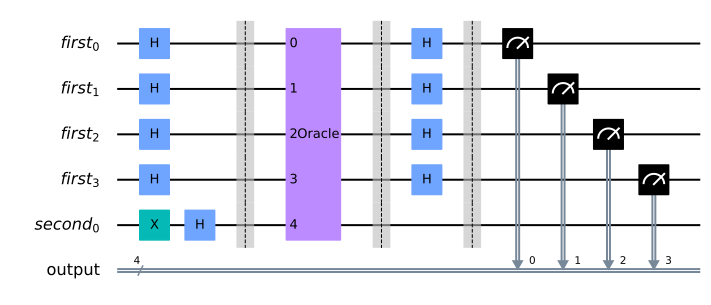

In [111]:
n=4
dj_circuit = full_dj_algorithm('balanced', n)
dj_circuit.draw()

In [95]:
aer_backend = BasicAer.get_backend('qasm_simulator')

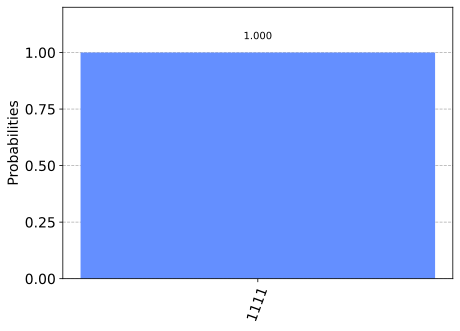

In [96]:
results = execute(dj_circuit, aer_backend, shots=1024).result().get_counts()
plot_histogram(results)

## With real devices

In [20]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
IBMQ_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", IBMQ_backend)

ibmqfactory.load_account:WARNING:2020-12-17 22:24:26,323: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_santiago


In [23]:
shots = 2048
job = execute(dj_circuit, IBMQ_backend, shots=shots, optimization_level=3)
job_monitor(job, interval=2)

Job Status: job has successfully run


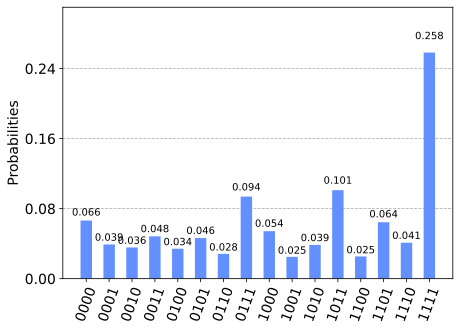

In [24]:
result = job.result().get_counts()
plot_histogram(result)

### Exercise

In [25]:
from qiskit_textbook.problems import dj_problem_oracle

In [55]:
n=4
qr_1 = QuantumRegister(n, name='first')
qr_2 = QuantumRegister(1, name='second')
c_out = ClassicalRegister(n, name='output')
results = []

for i in range(1,5):
    oracle = dj_problem_oracle(i)
    circuit = dj_algorithm(oracle, qr_1, qr_2, c_out)
    res = execute(circuit, aer_backend, shots=1024).result().get_counts()
    results.append(res)   

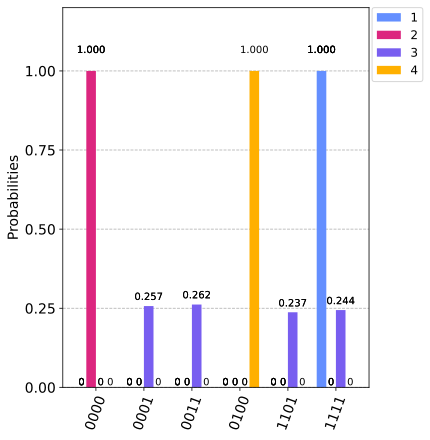

In [62]:
plot_histogram(results, figsize=(5.5,7), legend=range(1,5))

This results in the oracle 2 being the only constant one, while the others are all balanced.

In [97]:
state_backend = BasicAer.get_backend('statevector_simulator')

<IPython.core.display.Math object>

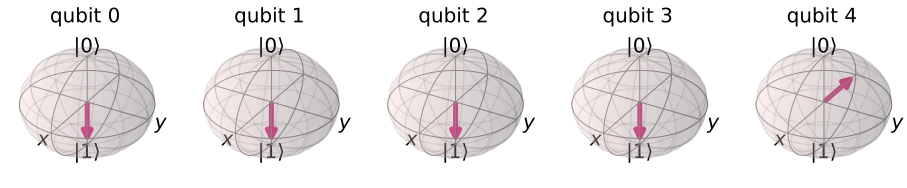

In [119]:
from qiskit_textbook.tools import array_to_latex
from qiskit.visualization import plot_bloch_multivector
state = execute(dj_circuit, state_backend, shots=1024).result().get_statevector()
array_to_latex(state)
plot_bloch_multivector(state)

The kind of balanced gates we used, the CNOTs wrapped in Xs, always put the first register in the $|1 \dots 1>$ state, after the hadamards have been applied. This is like in the working example, and the wrapping Xs only swap the phases and add up to a global phase between different sets of Xs applied to the register (check)